In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import gzip
from datetime import datetime, timedelta
from statistics import mean, median
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow
import tensorflow.keras as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Conv2D, Dropout
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
import csv
import random

from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import f1_score as f1

In [2]:
def retrieve_data(varname, filename):
    df = pd.read_csv(filename, index_col=0)
#     df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

def create_classification_data(df, lookback):
    rows = []
    columns = ['Date', 'US30_relative_change_perc_1'] # Date and SP500_relative_change_perc_1 from t-0 are added first as target variables 
    
    # create column names based on original with the addition of t-i where i is lookback
    for i in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
        new_columns = df.columns.tolist()[1:] # starts at 1 to exclude 'Date' column
        for x in range(len(new_columns)):
            new_columns[x] = new_columns[x] + "_t-" + str(i)
        columns = columns + new_columns
    
    # create lookback data
    for i, row in enumerate(df.iterrows()):
        if i > lookback: # lookback cannot be determined for earlier rows
            new_row = [row[1][0], row[1][1]] # add target 'Date' and 'SP500_relative_change_perc_1 '
            for x in range(1, lookback + 1): # starts at 1 since we do not want t-0 variables apart from 'Date' and 'SP500_relative_change_perc_1'
                add_row = df.iloc[i - x].tolist()[1:] # starts at 1 to exclude 'Date' column
                new_row = new_row + add_row
            rows.append(new_row)
    df2 = pd.DataFrame(rows)
    df2.columns = columns
    return df2

def create_train_val_test(df, year_val, year_test, perc_train=None):
    if perc_train == None:
        # assumes years_train < year_val < year_test
        df["Date"] = pd.to_datetime(df["Date"])
        
        val = df[df['Date'].dt.year == year_val]
        test = df[df['Date'].dt.year == year_test]
        train = df[df['Date'].dt.year < year_val]
    else:
        train = df.head(round(len(df) * perc_train))
        val = df.tail(len(df) - len(train))
        test = val.tail(round(0.5 * len(val)))
        val = df.head(len(val) - len(test))
    y_train = train['US30_relative_change_perc_1']
    x_train = train.drop(['US30_relative_change_perc_1'], axis=1)
    
    y_val = val['US30_relative_change_perc_1']
    x_val = val.drop(['US30_relative_change_perc_1'], axis=1)
    
    y_test = test['US30_relative_change_perc_1']
    x_test = test.drop(['US30_relative_change_perc_1'], axis=1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

def scale_data(x):
    standard_scaler = MinMaxScaler()
    x = x.drop(["Date"], axis=1)
    x_scaled = pd.DataFrame(standard_scaler.fit_transform(x), columns=x.columns)
    return x_scaled

In [3]:
lookback = 10
val_year = 2018
test_year = 2019

files = {
    # varname: filename
    "US30": "Dataset v3/US30_reduced_data_20220425.csv",
#     "S&P500": "Dataset v3/SP500_combined_data_20220422.csv"
}

for file in files:
    df = retrieve_data(file, files[file])

df = create_classification_data(df, lookback)

x_train, y_train, x_val, y_val, x_test, y_test = create_train_val_test(df, val_year, test_year)

In [4]:
y_train

0       0.003679
1       0.011674
2       0.007661
3      -0.003493
4       0.021051
5       0.002992
6       0.001696
7      -0.001120
8      -0.002378
9       0.008996
10      0.001857
11      0.012308
12      0.003785
13     -0.003692
14     -0.002256
15      0.012056
16     -0.003251
17     -0.009950
18      0.013593
19      0.003835
20     -0.008155
21     -0.019166
22      0.009150
23      0.007654
24      0.007706
25      0.016913
26      0.000326
27      0.003163
28      0.000515
29      0.004087
          ...   
2100    0.003981
2101   -0.003223
2102    0.002551
2103    0.003859
2104   -0.003011
2105    0.000222
2106    0.001185
2107    0.008953
2108    0.002404
2109    0.010767
2110   -0.003037
2111   -0.005489
2112   -0.006344
2113   -0.000701
2114    0.003934
2115    0.002716
2116    0.001969
2117    0.002120
2118    0.002456
2119   -0.004967
2120    0.002686
2121    0.002128
2122   -0.003206
2123   -0.004487
2124    0.000163
2125   -0.000403
2126    0.001229
2127    0.0003

In [5]:
def label_data(y):
    positives = []
    negatives = []
    y = list(y)
#     for dev in y:
#         if dev >= 0:
#             positives.append(dev)
#         else:
#             negatives.append(dev)
#     med_pos = median(positives)
#     med_neg = median(negatives)
    
    labels = []
    for dev in y:
        if dev >= 0:
            labels.append(1)
#             if dev >= med_pos:
#                 labels.append(2)
#             else:
#                 labels.append(1)
        else:
            labels.append(0)
#             if dev <= med_neg:
#                 labels.append(-2)
#             else:
#                 labels.append(-1)
    return labels
# 
y_train = label_data(y_train)
y_val = label_data(y_val)
y_test = label_data(y_test)

In [6]:
def random_baseline(y):
    counts = [0, 0]
    for i in y:
        if i == 0:
            counts[0] = counts[0] + 1
        elif i == 1:
            counts[1] = counts[1] + 1
    print(f"\tDistribution: {counts}")
    print(f"\tRandom baseline accuracy (majority class): {counts[np.argmax(np.asarray(counts))]/ len(y)}")
    
print("Random baseline training set")
random_baseline(y_train)
print("Random baseline validation set")
random_baseline(y_val)
print("Random baseline test set")
random_baseline(y_val)

Random baseline training set
	Distribution: [966, 1164]
	Random baseline accuracy (majority class): 0.5464788732394367
Random baseline validation set
	Distribution: [116, 135]
	Random baseline accuracy (majority class): 0.5378486055776892
Random baseline test set
	Distribution: [116, 135]
	Random baseline accuracy (majority class): 0.5378486055776892


In [7]:
train_date = x_train[['Date']]
x_train = x_train.drop(['Date'], axis=1)

val_date = x_val[['Date']]
x_val = x_val.drop(['Date'], axis=1)

test_date = x_test[['Date']]
x_test = x_test.drop(['Date'], axis=1)

In [8]:
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

print(x_train.shape, y_train.shape)

(2130, 180) (2130,)


In [9]:
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

# y_train = to_categorical(y_train, 1)
# y_val = to_categorical(y_val, 1)
# y_test = to_categorical(y_test, 1)

y_train = y_train.reshape((y_train.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

In [10]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)


(2130, 1, 180) (2130, 1)
(251, 1, 180) (251, 1)
(252, 1, 180) (252, 1)


In [22]:
# RESULT OPT 3 LAYERS
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)
# # lookback = 4
# epochs = 288
# batch_size = 256
# epochs = 257
# model = Sequential()
# model.add(Dense(49, activation='sigmoid'))
# model.add(Dropout(0.17))
# model.add(Dense(19, activation='sigmoid'))
# model.add(Dropout(0.06))
# model.add(Dense(81, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# # RESULT OPT 2 LAYERS
# tensorflow.random.set_seed(111)
# np.random.seed(111)
# random.seed(111)
# # lookback = 3
# epochs = 326
# epochs = 500
# epochs = 600
# batch_size = 128
# model = Sequential()
# model.add(Dense(24, activation='sigmoid'))
# model.add(Dropout(0.51))
# model.add(Dense(49, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# # RESULT OPT 1 LAYER
tensorflow.random.set_seed(111)
np.random.seed(111)
random.seed(111)
# lookback = 10
epochs = 359
epochs = 21
batch_size = 64
model = Sequential()
model.add(Dense(76, activation='sigmoid'))
model.add(Dropout(0.17))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val), shuffle=False)

Epoch 1/21
34/34 [==============================] - 1s 6ms/step - loss: 0.7506 - acc: 0.5576 - val_loss: 0.7083 - val_acc: 0.5299
Epoch 2/21
34/34 [==============================] - 0s 2ms/step - loss: 0.7077 - acc: 0.5426 - val_loss: 0.7071 - val_acc: 0.5179
Epoch 3/21
34/34 [==============================] - 0s 2ms/step - loss: 0.6980 - acc: 0.5638 - val_loss: 0.6962 - val_acc: 0.5378
Epoch 4/21
34/34 [==============================] - 0s 2ms/step - loss: 0.6882 - acc: 0.5461 - val_loss: 0.6995 - val_acc: 0.5299
Epoch 5/21
34/34 [==============================] - 0s 2ms/step - loss: 0.6954 - acc: 0.5420 - val_loss: 0.6968 - val_acc: 0.5498
Epoch 6/21
34/34 [==============================] - 0s 2ms/step - loss: 0.6919 - acc: 0.5537 - val_loss: 0.6996 - val_acc: 0.5339
Epoch 7/21
34/34 [==============================] - 0s 2ms/step - loss: 0.6833 - acc: 0.5658 - val_loss: 0.6907 - val_acc: 0.5418
Epoch 8/21
34/34 [==============================] - 0s 2ms/step - loss: 0.6925 - acc: 0.55

In [27]:
model_file = "Models/US30_NN_up-down_model"
model.save(model_file)

2022-05-06 10:59:36.021867: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Models/US30_NN_up-down_model/assets


In [24]:
def evaluate_convergence(history):
    epochs = []
    for i in range(len(history.history['loss'])):
        epochs.append(i)
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig1 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig1.add_trace(go.Scatter(x=epochs, y=train_loss, mode="lines", name="Train Loss"), row=1, col=1)
    fig1.add_trace(go.Scatter(x=epochs, y=val_loss, mode="lines", name="Validation Loss"), row=1, col=1)
    fig1.update_layout(
        title = "Training and Validation Loss Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Loss"),
    )
#     fig1.write_image()
    fig1.show()
    
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    fig2 = make_subplots(rows=1, cols=1, specs=[[{'type':'xy'}]])
    fig2.add_trace(go.Scatter(x=epochs, y=train_acc, mode="lines", name="Training Accuracy"), row=1, col=1)
    fig2.add_trace(go.Scatter(x=epochs, y=val_acc, mode="lines", name="Validation Accuracy"), row=1, col=1)
    fig2.update_layout(
        title = "Training and Validation Accuracy Convergence per Epoch", 
        xaxis1 = dict(title_text = "Epoch"),
        yaxis1 = dict(title_text = "Accuracy"),
    )
#     fig2.write_image()
    fig2.show()
    
evaluate_convergence(history)

In [25]:
def evaluate(model, x, y):
    y = y.tolist()
    y_pred = model.predict(x)
    y_pred = y_pred.round()
    y_pred = y_pred.tolist()
    
    for i in range(len(y)):
        y[i] = int(y[i][0])
        y_pred[i] = int(y_pred[i][0][0])
    
    acc = accuracy(y, y_pred)
    print(f"\tAccuracy: {acc}")
    
    prec = precision(y, y_pred)
    print(f"\tPrecision: {prec}")
    
    rec = recall(y, y_pred)
    print(f"\tRecall: {rec}")
    
    f = f1(y, y_pred)
    print(f"\tF1-score: {f}")
    
print("Training set evaluation")
evaluate(model, x_train, y_train)
print("Validation set evaluation")
evaluate(model, x_val, y_val)
print("Test set evaluation")
evaluate(model, x_test, y_test)

Training set evaluation
	Accuracy: 0.6253521126760564
	Precision: 0.6231493943472409
	Recall: 0.7955326460481099
	F1-score: 0.6988679245283018
Validation set evaluation
	Accuracy: 0.5816733067729084
	Precision: 0.5882352941176471
	Recall: 0.7407407407407407
	F1-score: 0.6557377049180328
Test set evaluation
	Accuracy: 0.5317460317460317
	Precision: 0.569060773480663
	Recall: 0.7202797202797203
	F1-score: 0.6358024691358024


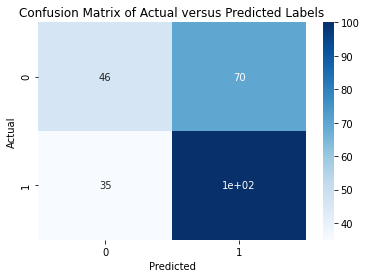

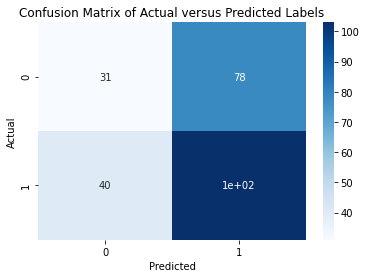

In [26]:
def confusion_matrix(model, x, y):
    y_pred = model.predict(x, batch_size=1)

    originals = []
    predictions = []

    for i in range(len(y_pred)):
        originals.append(y[i][0])
        predictions.append(round(float(y_pred[i][0])))
        
    df = pd.DataFrame()
    df['Actual'] = originals
    df['Predicted'] = predictions
    
    conf_matrix = pd.crosstab(df['Actual'], df['Predicted'])
    sns.heatmap(conf_matrix, annot=True, cmap='Blues')
    plt.title("Confusion Matrix of Actual versus Predicted Labels")
    plt.show()
    
# confusion_matrix(model, x_train, y_train)
confusion_matrix(model, x_val, y_val)
confusion_matrix(model, x_test, y_test)

In [16]:
def retrieve_candles(filename, val_year, test_year):
    df = pd.read_csv(filename)
    df["Date"] = pd.to_datetime(df["Date"])
    df.columns = ["Date", "Close", "Open", "High", "Low", "Vol.", "Change%"]
    df = df.sort_values('Date', ascending=True)
    
    candles_val = df[df['Date'].dt.year == val_year]
    candles_train = df[df['Date'].dt.year < val_year]
    candles_train = candles_train[candles_train['Date'] > datetime(2009,7,10)]
    
    candles_train = candles_train.replace(',','', regex=True)
    candles_val = candles_val.replace(',','', regex=True)

    return candles_train, candles_val

def plot_predictions_candles(x, y, df, dataset):
    # PREDICTIONS LIJKEN NOG NIET GOED UITGELIJND MET CANDLES???
    originals = []
    predictions = []
    y_pred = model.predict(x)
    for i in range(len(y_pred)):
        originals.append(y[i][0])
        predictions.append(round(float(y_pred[i][0])))

    fig = go.Figure()
    fig.add_trace(go.Candlestick(x=df['Date'], open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name="Price"))
    standard_factor = 0.5 * mean([float(df.iloc[0].tolist()[3]), float(df.iloc[0].tolist()[4])])
    
    green_legend = False
    orange_legend = False
    red_legend = False
    
    for i, row in enumerate(df.iterrows()):
        pred_date = row[1][0].to_pydatetime()
        pred_high = float(row[1][3])
        pred_low = float(row[1][4])
#         real_label = row[1][7]
#         pred_label = row[1][8]
        real_label = originals[i]
        pred_label = predictions[i]
        
        start_shape = pred_date - timedelta(days=0.1)
        end_shape = pred_date + timedelta(days=0.1)
    
        
        if pred_label == 1:
            extreme = pred_high + 0.1 * standard_factor
            standard = pred_high + 0.05 * standard_factor
#         elif pred_label == 2:
#             extreme = pred_high + 0.2 * standard_factor
#             standard = pred_high + 0.05 * standard_factor
        elif pred_label == 0:
            extreme = pred_low - 0.1 * standard_factor
            standard = pred_low -  0.05 * standard_factor
#         elif pred_label == -2:
#             extreme = pred_low - 0.2 * standard_factor
#             standard = pred_low - 0.05 * standard_factor
            
        if real_label == pred_label:
            color = "green"
#         elif np.sign(real_label) == np.sign(pred_label):
#             color = "orange"
        else:
            color = "red"
        
        if real_label == pred_label and not green_legend:
            green_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Correct Direction", mode="lines", line=dict(color=color)))
        
#         elif np.sign(real_label) == np.sign(pred_label) and not orange_legend:
#             orange_legend = True
#             fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
#                                  y=[standard,extreme,standard,standard], 
#                                  fill="toself", name="Correct Direction / Inorrect Magnitude", mode="lines", line=dict(color=color)))
        elif real_label != pred_label and not red_legend:
            red_legend = True
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", name="Incorrect Direction", mode="lines", line=dict(color=color)))
        else:
            fig.add_trace(go.Scatter(x=[start_shape,pred_date,end_shape,start_shape], 
                                 y=[standard,extreme,standard,standard], 
                                 fill="toself", showlegend=False, mode="lines", line=dict(color=color)))
    
    title = f"Visualization of {dataset} Predictions"
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Price")
    layout = dict(title=title, height=800, width=1500)
    fig.update_layout(layout)
#     config = dict({'scrollZoom': True})
#     fig.show(config=config)
    fig.show()

filename = "Dataset v3/Indices/S&P 500 Historical Data.csv"
candles_train, candles_val = retrieve_candles(filename, val_year, test_year) 
# plot_predictions_candles(x_train, y_train, candles_train, "Training")
plot_predictions_candles(x_val, y_val, candles_val, "Validation")